# Individual Project
# Practical Project (Convolutional Neural Networks)          Artificial Intelligence 1                                        Marks=40
           
This project is partially based on an assignment developed by Prof. Jonathan Rose and Harris Chan.

In this project, you will train a convolutional neural network to classify an image into one of two classes: "cat" or "dog". The code for the neural networks you train will be written for you, and you are not (yet!) expected to understand all provided code. However, by the end of the project, you should be able to:

1. Understand at a high level the training loop for a machine learning model.
2. Understand the distinction between training, validation, and test data.
3. The concepts of overfitting and underfitting.
4. Investigate how different hyperparameters, such as learning rate and batch size, affect the success of training.

# Do not panic, Enjoy Deep Leaning :-)

# Submission Instructions (precise and complete write-up)

Submit a PDF file containing all your code, outputs, and write-up from parts 1-4. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions has more information.

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission.

With Colab, you can export a PDF file using the menu option File -> Print and save as PDF file.

Only PDF file will be evaluated.

NOTE- Use Text cells wherever explaination is required. You can insert images by using the following code in code cell:

from google.colab import files

uploaded = files.upload()

from IPython.display import Image 

Image('NN.png',  width=800, height=500)

# Colab Link (Compulsory for Evaluation) I would not evaluate project without Colab link. Include here.

Colab Link:

Include a link to your colab file here



In [0]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms

# Part 0. Helper Functions
We will be making use of the following helper functions. You will be asked to look at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code after making some progress on the project.

In [0]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Returns the indices for datapoints in the dataset that
    belongs to the desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_train_indices = get_relevant_indices(
            trainset,
            classes,
            target_classes)
    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_train_indices)
    split = int(len(relevant_train_indices) * 0.8)
    relevant_train_indices, relevant_val_indices = relevant_train_indices[:split], relevant_train_indices[split:]
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

# Part 1. Visualizing the Data [7 pt]

We will make use of some of the CIFAR-10 data set, which consists of colour images of size 32x32 pixels belonging to 10 categories. You can find out more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html

For this assignment, we will only be using the cat and dog categories. We have included code that automatically downloads the dataset the first time that the main script is run.

In [4]:
# This will download the CIFAR-10 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=1) # One image per batch

0it [00:00, ?it/s]

170500096it [00:04, 39813893.64it/s]                               


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# Part (a) -- 1 pt
Visualize some of the data by running the code below. Include the visualization in your writeup.

(You don't need to submit anything else.)

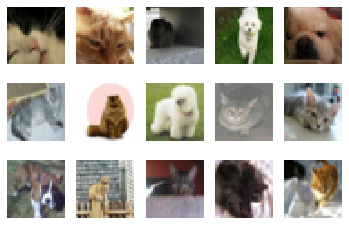

In [5]:
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

# Part (b) -- 3 pt
How many training examples do we have for the combined cat and dog classes? What about validation examples? What about test examples? (insert text cell to answer it)

In [6]:
print(len(train_loader))
print(len(test_loader))
print(len(val_loader))

8000
2000
2000


Training example :- 8000
Validation example :- 2000
Test example :- 2000
# This is modulated as code

# Part (c) -- 3pt
Why do we need a validation set when training our model? What happens if we judge the performance of our models using the training set loss/error instead of the validation set loss/error? (insert text cell to answer it)

Numerous machine learning alogrithms have a few parameters that can be tunned for higher precision. For case, In 'K overlap cross validation' higher esteem of K can be accomplished by tunning the model. Now,If we got to alter the demonstrate whereas preparing. We will do this by changing in Test Information that giving lower mistake value.But doing so will make the demonstrate more versatile to both testing and preparing data.In this case show may not perform well in case of unused unforseen data. Hence, we require another information set called Validation set that can offer assistance us to discover out the precise parameters and ML show. So, we are able say that the utilize of Approval set is for tunning hyper-parameters within the ML models.

A validation set may be a set of information utilized to prepare manufactured insights (AI) with the objective of finding and optimizing the finest demonstrate to unravel a given issue. Approval sets are too known as dev sets.

# Part 2. Training [15 pt]
We define two neural networks, a LargeNet and SmallNet. We'll be training the networks in this section.

You won't understand fully what these networks are doing until the next few classes, and that's okay. For this assignment, please focus on learning how to train networks, and how hyperparameters affect training.

In [0]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [0]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [0]:
small_net = SmallNet()
large_net = LargeNet()

# Part (a) -- 2pt
The methods small_net.parameters() and large_net.parameters() produces an iterator of all the trainable parameters of the network. These parameters are torch tensors containing many scalar values.

We haven't learned how the parameters in these high-dimensional tensors will be used, but we should be able to count the number of parameters. Measuring the number of parameters in a network is one way of measuring the "size" of a network.

What is the total number of parameters in small_net and in large_net? (Hint: how many numbers are in each tensor?)

(insert text cell to answer it)

In [10]:
for param in small_net.parameters():
    print(param.shape)

torch.Size([5, 3, 3, 3])
torch.Size([5])
torch.Size([1, 245])
torch.Size([1])


Total Parameter 386

In [11]:
for param in large_net.parameters():
    print(param.shape)

torch.Size([5, 3, 5, 5])
torch.Size([5])
torch.Size([10, 5, 5, 5])
torch.Size([10])
torch.Size([32, 250])
torch.Size([32])
torch.Size([1, 32])
torch.Size([1])


Total parameters 9705

# The function train_net

The function train_net below takes an untrained neural network (like small_net and large_net) and several other parameters. You should be able to understand how this function works. The figure below shows the high level training loop for a machine learning model:



In [12]:
from IPython.display import Image
Image('NN.png',  width=800, height=500)

In [0]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

# Part (b) -- 1pt
The parameters to the function train_net are hyperparameters of our neural network. We made these hyperparameters easy to modify so that we can tune them later on.

What are the default values of the parameters batch_size, learning_rate, and num_epochs? (insert text cell/section header cell to answer)

1) Batch-size characterizes the tally of preparing tests utilize in single emphasis of ML demonstrate preparing.. By default esteem of batch_size = 64 

2) learning-rate : It characterizes the sum of weights that get overhaul whereas preparing the demonstrate. It moreover controls the adjustment rate of the framework with regard to issue. By default esteem of learning-rate = 0.01 

3) num_epochs : It characterizes the number of cycle of program over the complete dataset that being utilized. By default esteem of num_epochs = 30

# Part (c) -- 3 pt
What files are written to disk when we call train_net with small_net, and train for 5 epochs? Provide a list of all the files written to disk, and what information the files contain.(insert text cell/section header cell to answer)

In [17]:
train_net(small_net,num_epochs=5)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.419625, Train loss: 0.6702918109893798 |Validation err: 0.3575, Validation loss: 0.6528013739734888
Epoch 2: Train err: 0.364125, Train loss: 0.6400804982185364 |Validation err: 0.365, Validation loss: 0.6536422856152058
Epoch 3: Train err: 0.347375, Train loss: 0.6269530177116394 |Validation err: 0.3455, Validation loss: 0.6232308987528086
Epoch 4: Train err: 0.336875, Train loss: 0.6142529735565185 |Validation err: 0.352, Validation loss: 0.6306113600730896
Epoch 5: Train err: 0.330625, Train loss: 0.6090599424839019 |Validation err: 0.356, Validation loss: 0.6238442920148373
Finished Training
Total time elapsed: 17.85 seconds


In [18]:
!dir

data				model_small_bs64_lr0.01_epoch4_train_err.csv
model_small_bs64_lr0.01_epoch0	model_small_bs64_lr0.01_epoch4_train_loss.csv
model_small_bs64_lr0.01_epoch1	model_small_bs64_lr0.01_epoch4_val_err.csv
model_small_bs64_lr0.01_epoch2	model_small_bs64_lr0.01_epoch4_val_loss.csv
model_small_bs64_lr0.01_epoch3	sample_data
model_small_bs64_lr0.01_epoch4


model_small_bs64_lr0.01_epoch4_train_err.csv
model_small_bs64_lr0.01_epoch0	model_small_bs64_lr0.01_epoch4_train_loss.csv
model_small_bs64_lr0.01_epoch1	model_small_bs64_lr0.01_epoch4_val_err.csv
model_small_bs64_lr0.01_epoch2	model_small_bs64_lr0.01_epoch4_val_loss.csv
model_small_bs64_lr0.01_epoch3	sample_data
model_small_bs64_lr0.01_epoch4

# Part (d) -- 2pt
Train both small_net and large_net using the function train_net and its default parameters. The function will write many files to disk, including a model checkpoint (saved values of model weights) at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive so that the files generated by train_net gets saved. We will be using these files in part (d). (See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train? Why?

In [20]:
# Since the function writes files to disk, you will need to mount
# your Google Drive. If you are working on the lab locally, you
# can comment out this code.

# from google.colab import drive
# drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [35]:
small_net=SmallNet()
train_net(small_net)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.439375, Train loss: 0.6837765421867371 |Validation err: 0.3915, Validation loss: 0.6662272289395332
Epoch 2: Train err: 0.380875, Train loss: 0.6527453322410584 |Validation err: 0.3935, Validation loss: 0.6626366525888443
Epoch 3: Train err: 0.342125, Train loss: 0.625328052520752 |Validation err: 0.3335, Validation loss: 0.6186922714114189
Epoch 4: Train err: 0.323875, Train loss: 0.6055600070953369 |Validation err: 0.339, Validation loss: 0.6171749532222748
Epoch 5: Train err: 0.314625, Train loss: 0.5930321733951569 |Validation err: 0.3215, Validation loss: 0.6096237320452929
Epoch 6: Train err: 0.29975, Train loss: 0.581014221906662 |Validation err: 0.3265, Validation loss: 0.6049923654645681
Epoch 7: Train err: 0.2975, Train loss: 0.5773153674602508 |Validation err: 0.3305, Validation loss: 0.600175685249269
Epoch 8: Train err: 0.295125, Train loss: 0.5693165059089661 |Validation err:

In [33]:
large_net=LargeNet()
train_net(large_net)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.44475, Train loss: 0.6900203099250793 |Validation err: 0.4285, Validation loss: 0.680754292756319
Epoch 2: Train err: 0.419125, Train loss: 0.678190191745758 |Validation err: 0.413, Validation loss: 0.6741814017295837
Epoch 3: Train err: 0.39875, Train loss: 0.6658317875862122 |Validation err: 0.391, Validation loss: 0.6517764702439308
Epoch 4: Train err: 0.374125, Train loss: 0.6491540780067444 |Validation err: 0.4095, Validation loss: 0.6662181690335274
Epoch 5: Train err: 0.35675, Train loss: 0.6333453297615051 |Validation err: 0.353, Validation loss: 0.6291991733014584
Epoch 6: Train err: 0.33925, Train loss: 0.6163788948059082 |Validation err: 0.344, Validation loss: 0.6148867644369602
Epoch 7: Train err: 0.327875, Train loss: 0.6005767168998718 |Validation err: 0.3315, Validation loss: 0.6076090820133686
Epoch 8: Train err: 0.311875, Train loss: 0.5835636842250824 |Validation err: 0.

The total time taken for small net is 112.92 seconds and the time taken for large net is 124.32 seconds. Thats because it contains more nodes and has to maintain more weight.

# Part (e) - 2pt
Use the function plot_training_curve to display the trajectory of the training/validation error and the training/validation loss. You will need to use the function get_model_name to generate the argument to the plot_training_curve function.

Do this for both the small network and the large network. Include both plots in your writeup. 

(include in your colab) you can use the following code to insert any images/plots to your colab 

from google.colab import files

uploaded = files.upload()

from IPython.display import Image 

Image('NN.png',  width=800, height=500)

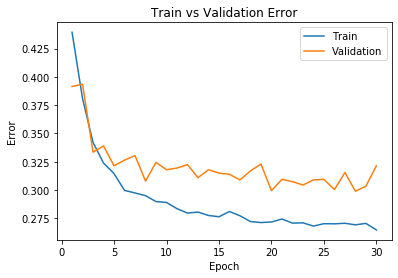

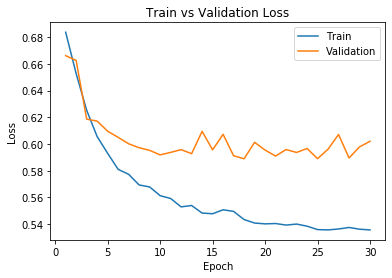

In [36]:
model_path = get_model_name("small", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)

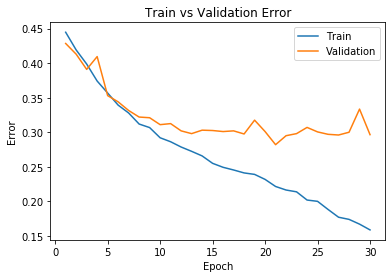

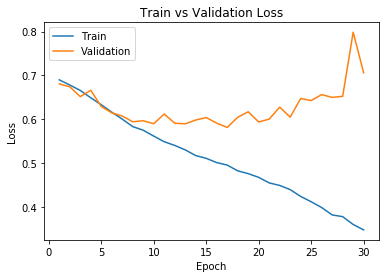

In [19]:
model_path = get_model_name("large", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)

There's a enormous distinction in approval misfortune and preparing misfortune in case of large net so we are able say its a case of overfiting though the distinction in validation

# Part (f) - 5pt
Describe what you notice about the training curve. How do the curves differ for small_net and large_net? Identify any occurences of underfitting and overfitting.

There's a exceptional distinction between preparing and approval mistakes between expansive net and little net show. As the approval mistake is higher than the preparing blunder to a colossal esteem in huge net, there may be a chance of overfitting to occur. The approval mistake and preparing mistake both are at a really higher level. This could cause underfitting. Whereas little net takes lesser time, it's precision cannot be guaranteed, in this way it cannot find all highlights.

# Part 3. Optimization Parameters [12 pt]
For this section, we will work with large_net only.

# Part (a) - 3pt
Train large_net with all default parameters, except set learning_rate=0.001. Does the model take longer/shorter to train? Plot the training curve. Describe the effect of lowering the learning rate.

In [21]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()
train_net (large_net, batch_size=64, learning_rate=0.001, num_epochs=30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.50225, Train loss: 0.6945205426216126 |Validation err: 0.491, Validation loss: 0.6929904446005821
Epoch 2: Train err: 0.50225, Train loss: 0.6930276579856872 |Validation err: 0.491, Validation loss: 0.6924118660390377
Epoch 3: Train err: 0.48725, Train loss: 0.6922532424926758 |Validation err: 0.4765, Validation loss: 0.6920256800949574
Epoch 4: Train err: 0.448875, Train loss: 0.6916870546340942 |Validation err: 0.4515, Validation loss: 0.6913814526051283
Epoch 5: Train err: 0.442375, Train loss: 0.6910721230506897 |Validation err: 0.4415, Validation loss: 0.6910948026925325
Epoch 6: Train err: 0.440375, Train loss: 0.6903762569427491 |Validation err: 0.4375, Validation loss: 0.6905079521238804
Epoch 7: Train err: 0.437875, Train loss: 0.6895530533790588 |Validation err: 0.434, Validation loss: 0.6896945498883724
Epoch 8: Train err: 0.43925, Train loss: 0.6884702944755554 |Validation err:

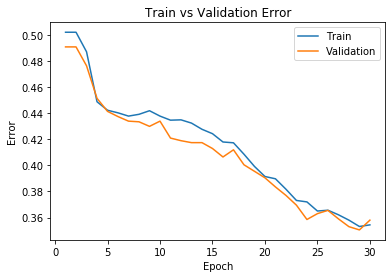

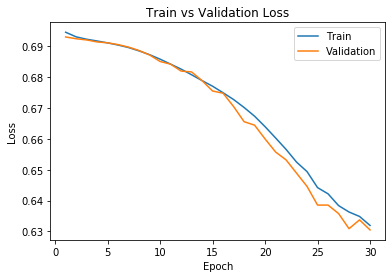

In [22]:
model_path = get_model_name("large", batch_size=64, learning_rate=0.001, epoch=29)
plot_training_curve(model_path)

Learning rate is indirectly proportional to jump between epoch in validation error.

# Part (b) - 3pt
Train large_net with all default parameters, except set learning_rate=0.1. Does the model take longer/shorter to train? Plot the training curve. Describe the effect of increasing the learning rate.

In [23]:
large_net = LargeNet()
train_net (large_net, batch_size=64, learning_rate=0.01, num_epochs=30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.44475, Train loss: 0.6900203099250793 |Validation err: 0.4285, Validation loss: 0.680754292756319
Epoch 2: Train err: 0.419125, Train loss: 0.678190191745758 |Validation err: 0.413, Validation loss: 0.6741814017295837
Epoch 3: Train err: 0.39875, Train loss: 0.6658317875862122 |Validation err: 0.391, Validation loss: 0.6517764702439308
Epoch 4: Train err: 0.374125, Train loss: 0.6491540780067444 |Validation err: 0.4095, Validation loss: 0.6662181690335274
Epoch 5: Train err: 0.35675, Train loss: 0.6333453297615051 |Validation err: 0.353, Validation loss: 0.6291991733014584
Epoch 6: Train err: 0.33925, Train loss: 0.6163788948059082 |Validation err: 0.344, Validation loss: 0.6148867644369602
Epoch 7: Train err: 0.327875, Train loss: 0.6005767168998718 |Validation err: 0.3315, Validation loss: 0.6076090820133686
Epoch 8: Train err: 0.311875, Train loss: 0.5835636842250824 |Validation err: 0.

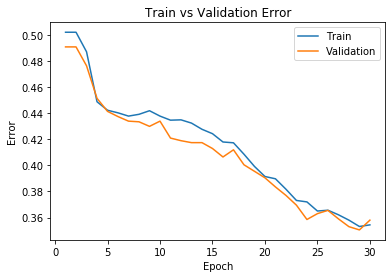

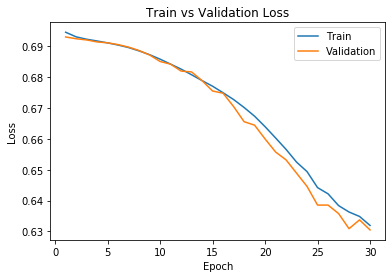

In [24]:
model_path = get_model_name("large", batch_size=64, learning_rate=0.001, epoch=29)
plot_training_curve(model_path)

Its visible that there is a huge variation in the validation error values where with the default parameters it goes to 0.3 while the value with learning rate of 0.1 rises to 0.4

# Part (c) - 3pt
Train large_net with all default parameters, including with learning_rate=0.01. Now, set batch_size=512. Does the model take longer/shorter to train? Plot the training curve. Describe the effect of increasing the batch size.

In [25]:
large_net = LargeNet()
train_net (large_net, batch_size=512, learning_rate=0.01, num_epochs=30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48175, Train loss: 0.6929379403591156 |Validation err: 0.478, Validation loss: 0.6926823854446411
Epoch 2: Train err: 0.457625, Train loss: 0.6924103908240795 |Validation err: 0.434, Validation loss: 0.6917425096035004
Epoch 3: Train err: 0.437, Train loss: 0.6916500441730022 |Validation err: 0.4265, Validation loss: 0.6909130066633224
Epoch 4: Train err: 0.433625, Train loss: 0.6908450052142143 |Validation err: 0.424, Validation loss: 0.6897870898246765
Epoch 5: Train err: 0.434, Train loss: 0.6896936446428299 |Validation err: 0.424, Validation loss: 0.6881358623504639
Epoch 6: Train err: 0.43825, Train loss: 0.6883534081280231 |Validation err: 0.428, Validation loss: 0.68601293861866
Epoch 7: Train err: 0.439375, Train loss: 0.6866869702935219 |Validation err: 0.426, Validation loss: 0.6836968064308167
Epoch 8: Train err: 0.435375, Train loss: 0.6849769502878189 |Validation err: 0.412, V

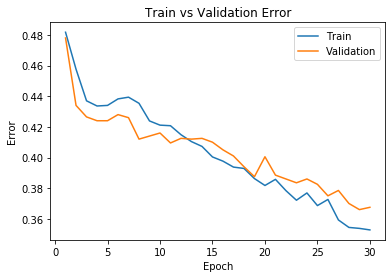

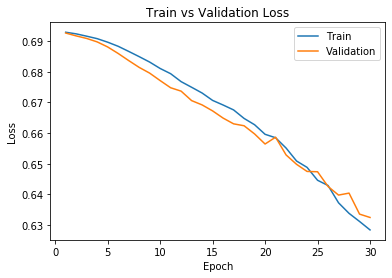

In [26]:
model_path = get_model_name("large", batch_size=512, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)

The preparing for clump estimate 512 and learning rate 0.01 for expansive net is much lesser compared to the default esteem. At most of the locales, the preparing blunder is over approval mistake which may cause slight underfitting. Other than that, the chart shows up indeed.

# Part (d) - 3pt
Train large_net with all default parameters, including with learning_rate=0.01. Now, set batch_size=16. Does the model take longer/shorter to train? Plot the training curve. Describe the effect of decreasing the batch size.

In [27]:
large_net = LargeNet()
train_net (large_net, batch_size=16, learning_rate=0.01, num_epochs=30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.43175, Train loss: 0.6774821187257767 |Validation err: 0.378, Validation loss: 0.651921395778656
Epoch 2: Train err: 0.36875, Train loss: 0.6395755406022072 |Validation err: 0.3595, Validation loss: 0.6264406447410583
Epoch 3: Train err: 0.33875, Train loss: 0.6120929001569748 |Validation err: 0.3475, Validation loss: 0.6289729187488556
Epoch 4: Train err: 0.314375, Train loss: 0.5869516692757607 |Validation err: 0.3545, Validation loss: 0.6142054274082184
Epoch 5: Train err: 0.3115, Train loss: 0.5694829801917076 |Validation err: 0.312, Validation loss: 0.5763112711906433
Epoch 6: Train err: 0.281125, Train loss: 0.5458917077481746 |Validation err: 0.2985, Validation loss: 0.5741617560386658
Epoch 7: Train err: 0.269875, Train loss: 0.5297637034058571 |Validation err: 0.309, Validation loss: 0.6013907868862152
Epoch 8: Train err: 0.257375, Train loss: 0.5129605046510697 |Validation err: 0

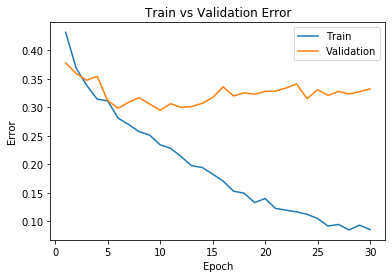

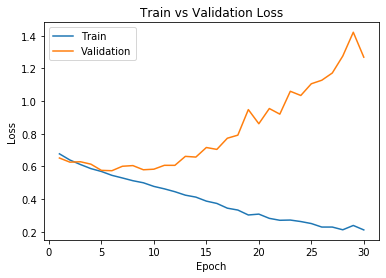

In [28]:
model_path = get_model_name("large", batch_size=16, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)

From the graph, ready to see a huge difference between the approval and preparing blunder which may be a beyond any doubt sign of overfitting. Hence diminishing the clump measure increments the time for preparing.

# Part 4. Hyperparameter Search [6 pt]
# Part (a) - 2pt
Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate) that you think would help you improve the validation accuracy. Justify your choice.

As per the comes about in area 3, I have choosen higher batch_size because it will diminished the preparing demonstrate time and littler learning rate will diminish the changes between prepare and approval misfortune by altering the weights and inclination. Here the case will be underfitting as the batch_size has been expanded.

# Part (b) - 1pt
Train the model with the hyperparameters you chose in part(a), and include the training curve

In [47]:
large_net = LargeNet()
train_net (large_net, batch_size=1024, learning_rate=0.07, num_epochs=30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.47775, Train loss: 0.6927754729986191 |Validation err: 0.4385, Validation loss: 0.6920537650585175
Epoch 2: Train err: 0.452625, Train loss: 0.6915609389543533 |Validation err: 0.449, Validation loss: 0.6895136535167694
Epoch 3: Train err: 0.444625, Train loss: 0.6890449300408363 |Validation err: 0.4275, Validation loss: 0.6853166222572327
Epoch 4: Train err: 0.43225, Train loss: 0.6852255761623383 |Validation err: 0.4165, Validation loss: 0.6789893805980682
Epoch 5: Train err: 0.423125, Train loss: 0.6804191321134567 |Validation err: 0.415, Validation loss: 0.6744290888309479
Epoch 6: Train err: 0.413625, Train loss: 0.6747964099049568 |Validation err: 0.4115, Validation loss: 0.6682469546794891
Epoch 7: Train err: 0.403, Train loss: 0.6693854480981827 |Validation err: 0.4015, Validation loss: 0.6640462279319763
Epoch 8: Train err: 0.3925, Train loss: 0.6644827201962471 |Validation err: 0

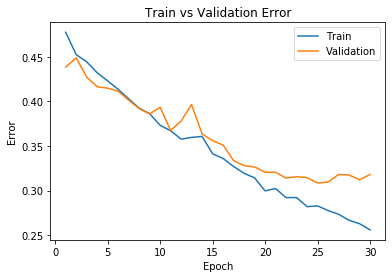

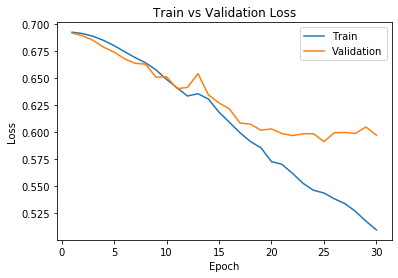

In [48]:
model_path = get_model_name("large", batch_size=1024, learning_rate=0.07, epoch=29)
plot_training_curve(model_path)

s chosen as a higher batch size as it takes lesser time to train and overfitting is prevented with a lesser learning rate

# Part (c) - 2pt
Based on your result from Part(a), suggest another set of hyperparameter values to try. Justify your choice.

Another set of hyperparameters that can be chosen is a batch size of 512 and learning rate of 0.008. As the earliar graph showed an increment in speed and an nearly smooth chart, as it were a slight fine tuning was required to adjust the preparing and approval mistake values. This way a adjust between preparing time and exactness is kept up.

# Part (d) - 1pt
Train the model with the hyperparameters you chose in part(c), and include the training curve.

In [31]:
large_net = LargeNet()
train_net (large_net, batch_size=1048, learning_rate=0.04, num_epochs=30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.481, Train loss: 0.692917063832283 |Validation err: 0.4695, Validation loss: 0.6925272643566132
Epoch 2: Train err: 0.454125, Train loss: 0.692212201654911 |Validation err: 0.4435, Validation loss: 0.6911147236824036
Epoch 3: Train err: 0.4465, Train loss: 0.6909240931272507 |Validation err: 0.4255, Validation loss: 0.6894970834255219
Epoch 4: Train err: 0.43225, Train loss: 0.689319983124733 |Validation err: 0.4205, Validation loss: 0.6867187917232513
Epoch 5: Train err: 0.436, Train loss: 0.6866013035178185 |Validation err: 0.4255, Validation loss: 0.6826579570770264
Epoch 6: Train err: 0.433375, Train loss: 0.6839847713708878 |Validation err: 0.412, Validation loss: 0.678908497095108
Epoch 7: Train err: 0.427, Train loss: 0.6805525869131088 |Validation err: 0.415, Validation loss: 0.6759096682071686
Epoch 8: Train err: 0.416375, Train loss: 0.6768683791160583 |Validation err: 0.4115, Va

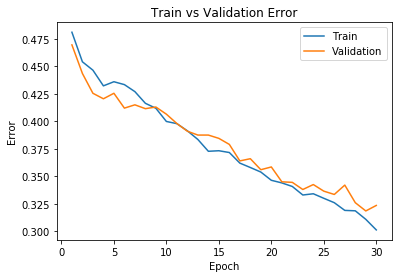

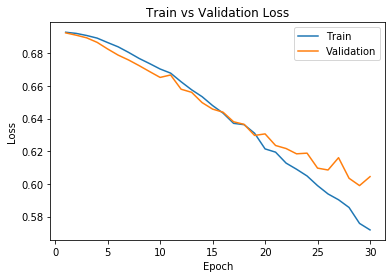

In [32]:
model_path = get_model_name("large", batch_size=1048, learning_rate=0.04, epoch=29)
plot_training_curve(model_path)